# 6. Filtro de Kalman

El filtro de Kalman es muy aplicado en el área de sistemas de navegación, GPS, robótica, procesamiento de señales y otras aplicaciones de ingeniería. Basicamente esta técnica filtra el ruido que contienen las mediciones de un fenómeno en particular; por ejemplo, si se desea saber la posición de un avión, las señales que captan el radar contienen además de la posición del avión ruido debido a muchas otras variables que afectan la medición. El filtro de Kalman "limpia" en tiempo real esta información y arroja la variable que deseamos observar que en este ejemplo es la posición de un avión.

La aplicación del filtro de Kalman no se ha limitado al ámbito de las ingenierías sino que tambien es empleado en el análisis de las series de tiempo. Como veremos, todos los modelos ARMA y VAR que hemos visto tienen una representación suceptible a la aplicación del filtro de Kalman. Finalmente, la economía no ha estado ajena al uso de esta técnica como en el caso de la estimación de regresiones con coeficientes variables en el tiempo.

### 6.1 Representación Estado-Espacio

Antes de ver el filtro de Kalman en sí, es importante estudiar la representación Estado-Espacio sobre la que se define el filtro de Kalman. Supongamos que tenemos un vector $\mathbf{y}_t$ de $n$ variables observadas con una muestra que va de $t = 1, 2, \dots, T$. Adicionalmente contamos con $k$ variables exógenas $\mathbf{x}_t$ que también son observadas. La representación Estado-Espacio sería:

$$\mathbf{\xi}_{t + 1} = \mathbf{F}\mathbf{\xi}_t + \mathbf{v}_{t + 1}$$
$$\mathbf{y}_t = \mathbf{A}'\mathbf{x}_t + \mathbf{H}'\mathbf{\xi}_t + \mathbf{w}_t$$

donde $\mathbf{\xi}_t$ es el vector de variables estado. Una variable estado es aquella que representa la situación actual de un sistema dinámico y nos permite saber el estado futuro del sistema dinámico. Esta variable es no observable y es de dimensión $r$. $\mathbf{A}'$ es una matriz $n \times k$, $\mathbf{F}$ es una matriz $r \times r$ y $\mathbf{H}'$ es una matriz $n \times r$. La primera ecuación se la conoce como la **ecuación estado** y la segunda ecuación se la conoce como la **ecuación de observación** o la **ecuación de medición**. El filtro de Kalman es un algoritmo que nos permite extraer de las mediciones obtenidas, las respectivas variables estado que nos interesa conocer.

Se asume que los errores de ambas ecuaciones son procesos ruido blanco no correlacionados entre si. Es decir:

$$E(\mathbf{v}_t\mathbf{v}'_\tau) = \left\{\begin{array}{l} \mathbf{Q} \text{ para } t = \tau \\
                                                           \mathbf{0} \text{ de lo contrario }\end{array}\right.$$
$$E(\mathbf{w}_t\mathbf{w}'_\tau) = \left\{\begin{array}{l} \mathbf{R} \text{ para } t = \tau \\
                                                           \mathbf{0} \text{ de lo contrario }\end{array}\right.$$
$$E(\mathbf{v}_t\mathbf{w}'_\tau) = \mathbf{0} \text{ para todo $t$ y $\tau$}$$

Esta representación Estado-Espacio es muy flexible y es posible relajar el supuesto de no correlación entre los errores de la ecuación de estado y la ecuación de observación. Adicionalmente, las matrices $\mathbf{F, Q, A, H, R}$ pueden estar en función del tiempo, eso lo veremos más adelante.


Supongamos el siguiente proceso AR(1):

$$y_{t + 1} = 0.7 y_t + \epsilon_{t + 1}$$

donde $\epsilon_t$ es un proceso i.i.d $\sim N(0, 4)$. Podemos expresar este modelo en la forma Estado-Espacio. La ecuación de estado sería:

$$y_{t + 1} = 0.7 y_t + \epsilon_{t + 1}$$

y la ecuación de observación sería:

$$y_t = y_t$$

donde: $\mathbf{\xi}_t = y_t$, $\mathbf{v}_{t + 1} = \epsilon_{t + 1}$, $\mathbf{F} = 0.7$, $\mathbf{A}' = 0$ , $\mathbf{H}'= 1$, $\mathbf{Q} = 4$, $\mathbf{R} = 0$, $\mathbf{x}_t = 0$ y $\mathbf{w}_t = 0$.

Ahora consideremos un modelo MA(1):

$$y_t = 1.4 + \epsilon_t + 0.7 \epsilon_{t - 1}$$

donde $\epsilon_t$ es un proceso i.i.d $\sim N(0, 2)$. La ecuación de estado sería:

$$\left[\begin{array}{c} \epsilon_{t + 1} \\
                         \epsilon_t\end{array}\right] = \left[\begin{array}{cc} 0 & 0 \\
                                                                                1 & 0\end{array}\right] \left[\begin{array}{c} \epsilon_t \\
    \epsilon_{t - 1} \end{array}\right] + \left[\begin{array}{c} \epsilon_{t + 1} \\
                                                                  0 \end{array}\right]$$

y la ecuación de observación sería:

$$y_t = 1.4 + \left[\begin{array}{cc} 1 & 0.7 \end{array}\right]\left[\begin{array}{c} \epsilon_t \\
                                                                                       \epsilon_{t - 1}\end{array}\right]$$

donde: $\mathbf{\xi}_t = \left[\begin{array}{c} \epsilon_t \\
                                                \epsilon_{t - 1}\end{array}\right]$, $\mathbf{F} = \left[\begin{array}{cc} 0 & 0 \\
1 & 0 \end{array}\right]$, $\mathbf{v}_{t + 1} = \left[\begin{array}{c} \epsilon_{t + 1} \\
                                                                         0 \end{array}\right]$, $\mathbf{Q} = \left[\begin{array}{c c} 2 & 0 \\
                         0 & 0 \end{array}\right]$, $\mathbf{y}_t = y_t$, $\mathbf{A}' = 1.4$, $\mathbf{x}_t = 1$, $\mathbf{H}' = \left[\begin{array}{cc} 1 & 0.7 \end{array}\right]$, $\mathbf{w}_t = 0$ y $\mathbf{R} = 0$.

Finalmente, podemos hacer algo similar con el siguiente modelo ARMA(1, 1):

$$y_t = 0.5 y_{t - 1} + \epsilon_t + 0.6 \epsilon_{t - 1}$$

donde $\epsilon_t$ es un proceso i.i.d $\sim N(0, 3)$. La ecuación estado sería:

$$\mathbf{\xi}_{t + 1} = \left[\begin{array}{cc} 0.5  & 0 \\
                                                  1   & 0 \\\end{array}\right]\mathbf{\xi}_t + \left[\begin{array}{c} \epsilon_{t + 1} \\
0\end{array}\right] $$

y la ecuación de observación vendría dada por:

$$y_t = \left[\begin{array}{cc} 1 & 0.6\end{array}\right]\mathbf{\xi}_t$$

donde $\mathbf{\xi}_t = \left[\begin{array}{c} \xi_{1t} \\
                                               \xi_{2t} \end{array}\right]$, $\mathbf{F} = \left[\begin{array}{cc} 0.5 & 0 \\
1 & 0 \end{array} \right]$, $\mathbf{v}_{t + 1} = \left[\begin{array}{c}\epsilon_{t + 1} \\
                                                                        0 \end{array}\right]$, $\mathbf{Q} = \left[\begin{array}{cc} 3 & 0 \\
                        0 & 0 \end{array}\right]$, $\mathbf{y}_t = y_t$, $\mathbf{A}' = 0$, $\mathbf{x}_t = 0$, $\mathbf{H}' = \left[\begin{array}{cc} 1 & 0.6\end{array}\right]$, $\mathbf{w}_t = 0$ y $\mathbf{R} = 0$.  

Entonces todo modelo ARMA(p, q) y VARMA(p, q) puede expresarse como una representación Estado-Espacio. 

### 3.2 Derivación del Filtro de Kalman

El objetivo del filtro de Kalman es extraer de las observaciones que contamos, los valores de las variables estado o no observables de nuestro modelo $\mathbf{\xi}_t$. Imaginemos que contamos con un vector información $\mathcal{Y}_t$ en el periodo $t$, donde:

$$\mathcal{Y}_t = (\mathbf{y}'_t, \mathbf{y}'_{t - 1}, \dots, \mathbf{y}'_1, \mathbf{x}'_t, \mathbf{x}_{t - 1}, \dots, \mathbf{x}'_1)'$$ 

Nuestro objetivo con el filtro de Kalman es obtener el pronóstico $\mathbf{\hat{\xi}}_{t + 1|t}$ en base a este vector de información. Es decir:

$$\mathbf{\hat{\xi}}_{t + 1|t} = \hat{E}(\mathbf{\xi}_{t + 1}|\mathcal{Y}_t)$$

con un error cuadrático medio de este pronóstico MSE de:

$$\mathbf{P}_{t + 1|t} = E[(\mathbf{\xi}_{t + 1} - \mathbf{\hat{\xi}}_{t + 1|t})(\mathbf{\xi}_{t + 1} - \mathbf{\hat{\xi}}_{t + 1|t})']$$

Para inicializar el filtro necesitamos valores de $\mathbf{\xi}_{1|0}$ y $\mathbf{P}_{1|0}$ es decir el pronóstico de las variables estado en base a información en el periodo 0 y también para su error cuadrático medio. Como no hay datos en el periodo 0, se toma como valor inicial la esperanza no condicional de la variable estado en el periodo 1, es decir:

$$\mathbf{\xi}_{1|0} = E(\mathbf{\xi}_1)$$.

Si los autovalores de la matriz $\mathbf{F}$ están dentro del círculo unitario o son menores a 1 en módulo entonces las variables estado siguen un proceso estacionario donde la media no condicional es igual para todos los periodos:

$$E(\mathbf{\xi}_t) = \mathbf{0}$$

y un MSE de:

$$vec(\Sigma) = [I_{r^2} - (\mathbf{F}\otimes \mathbf{F})]^{-1}vec(Q)$$

entonces si uno considera que el vector de variables estado sigue un proceso estacionario se pueden considerar como valores iniciales de $\mathbf{\xi}_{1|0}$ y de $\mathbf{P}_{1|0}$ los resultados mencionados. Si en caso el proceso de las variables estado no es estacionario entonces el analista define de acuerdo a su criterio los valores iniciales.

El primer paso en el desarrollo del algoritmo del Filtro de Kalman es en determinar el pronóstico de $y_t$ que lo podemos expresar como:

$$\mathbf{\hat{y}}_{t|t -1} = \hat{E}(\mathbf{y}_t|\mathcal{Y}_{t - 1})$$

lo que sería igual a:

$$\mathbf{\hat{y}}_{t|t - 1} = \mathbf{A}'\mathbf{x}_t + \mathbf{H}'\mathbf{\hat{\xi}}_{t|t - 1}$$

con un MSE de:

$$E[(\mathbf{y}_t - \mathbf{\hat{y}}_{t|t - 1})(\mathbf{y}_t - \mathbf{\hat{y}}_{t|t - 1})'] = \mathbf{H}'\mathbf{P}_{t|t - 1}\mathbf{H} + R$$

Una vez que contamos con la proyeccion inicial de las variables estado y las proyecciones de las variables observadas, tenemos que **actualizar** nuestra proyección inicial de las variables estado y en general todas las proyecciones de las variables estado con la nueva información que brinda $\mathbf{y}_t$, tenemos:

$$\mathbf{\hat{\xi}}_{t|t} = \hat{E}(\mathbf{\xi}_t | \mathbf{y}_t, \mathcal{Y}_{t - 1}) = \hat{E}(\mathbf{\xi}_t | \mathcal{Y}_t)$$

Utilizando la fórmula de actualización de proyecciones:

$$\mathbf{\hat{\xi}}_{t|t} = \mathbf{\hat{\xi}}_{t|t - 1} + E[(\mathbf{\xi}_t - \mathbf{\hat{\xi}}_{t|t-1})(\mathbf{y}_t - \mathbf{\hat{y}}_{t|t - 1})'] \times E[(\mathbf{y}_t - \mathbf{\hat{y}}_{t|t - 1})(\mathbf{y}_t - \mathbf{\hat{y}}_{t|t - 1})']^{-1} (\mathbf{y}_t - \mathbf{\hat{y}}_{t|t - 1})$$

Reemplazando obtenemos:

$$\mathbf{\hat{\xi}}_{t|t} = \mathbf{\hat{\xi}}_{t|t-1} + \mathbf{P}_{t|t-1}\mathbf{H}(\mathbf{H}'\mathbf{P}_{t|t-1}\mathbf{H} + \mathbf{R})^{-1}(\mathbf{y}_t - \mathbf{A}'\mathbf{x}_t - \mathbf{H}'\mathbf{\hat{\xi}}_{t|t - 1})$$

El MSE asociado es:

$$\mathbf{P}_{t|t} = \mathbf{P}_{t|t - 1} - \mathbf{P}_{t|t - 1}(\mathbf{H}'\mathbf{P}_{t|t - 1}\mathbf{H} + \mathbf{R})^{-1}\mathbf{H}'\mathbf{P}_{t|t - 1}$$

Una vez actualizadas las proyecciones para las variables estado, se las proyecta nuevamente:

$$\mathbf{\hat{\xi}}_{t + 1|t} = \mathbf{F}\mathbf{\hat{\xi}}_{t|t}$$

con un MSE asociado:

$$\mathbf{P}_{t + 1|t} = \mathbf{F}\mathbf{P}_{t|t}\mathbf{F}' + \mathbf{Q}$$

En resumen, el filtro de Kalman es descrito en estos 4 pasos:

1. Calcular o darse valores iniciales de $\mathbf{\hat{\xi}}_{1|0}$ y de $\mathbf{P}_{1|0}$.
2. Actualizar las proyecciones de las variables estado con un nuevo vector de datos observados $\mathbf{y}_t$.
3. Proyectar las variables estado con información hasta $t$.
4. Repetir los pasos 3 y 4 hasta concluir con la muestra.

El filtro de Kalman es una técnica sencilla que puede fácilmente ser implementada en R para el caso univariante.

In [7]:
FiltroKalman <- function(y, x, F, A, H, Q, R, E_ini, P_ini) {
    T <- length(y)
    E_u <- rep(0, T)
    E_f <- rep(0, (T + 1)) 
    E_f[1] <- E_ini
    P_u <- rep(0, T)
    P_f <- rep(0, (T + 1))
    P_f[1] <- P_ini
    for (i in 1:T) {
        # 1. Actualizar pronósticos
        E_u[i] <- E_f[i] + P_f[i] * H * (H^2 * P_f[i] + R)^(-1) * (y[i] - A * x[i] - H * E_f[i])
        P_u[i] <- P_f[i] - P_f[i] * H * (H^2 * P_f[i] + R)^(-1) * H * P_f[i]
        # 2. Realizar los pronósticos
        E_f[i + 1] <- F * E_u[i]
        P_f[i + 1] <- F^2 * P_u[i] + Q
    }
    results <- list(E_u = E_u, P_u = P_u, E_f = E_f, P_f = P_f)    
    return(results)
}

Supongamos que la variable estado sigue un proceso AR(1):

$$\xi_{t + 1} = 0.7 \xi_t + v_{t + 1}$$

donde $v_t \sim N(0, 2)$. La ecuación de observación sería:

$$y_t = 1.3\xi_t + w_t$$

donde $w_t \sim N(0, 3)$. Entonces $\mathbf{F} = 0.7$, $\mathbf{v}_{t + 1} = v_{t + 1}$, $\mathbf{Q} = 2$, $\mathbf{A}' = 0$, $\mathbf{x}_t = 0$, $\mathbf{H}' = 1.3$, $\mathbf{w}_{t + 1} = w_{t + 1}$ y $\mathbf{R} = 3$.

In [2]:
# 1. Simulamos la Variable Estado y la observación
set.seed(12345)
v <- rnorm(100, mean = 0, sd = sqrt(2))
E_sim <- rep(0, 100)
for (i in 2:100) {
    E_sim[i] <- 0.7 * E_sim[i - 1] + v[i]
}

In [3]:
# 2. Simulación de la variable observación
w <- rnorm(100, mean = 0, sd = sqrt(3))
y <- rep(0, 100)
for (i in 1:100) {
    y[i] <- 1.3 * E_sim[i] + w[i]
}

In [29]:
# 3. Estimación de la variable estado por el Filtro de Kalman
F <- 0.7; Q = 2; A = 0; x <- rep(0, 100); H <- 1.3; R <- 3; E_ini = 0; P_ini = 100
res <- FiltroKalman(y, x, F, A, H, Q, R, E_ini, P_ini)

In [32]:
datos <- data.frame(t = 1:100, E_sim = E_sim, E_est = res$E_u)

In [31]:
library(ggplot2)

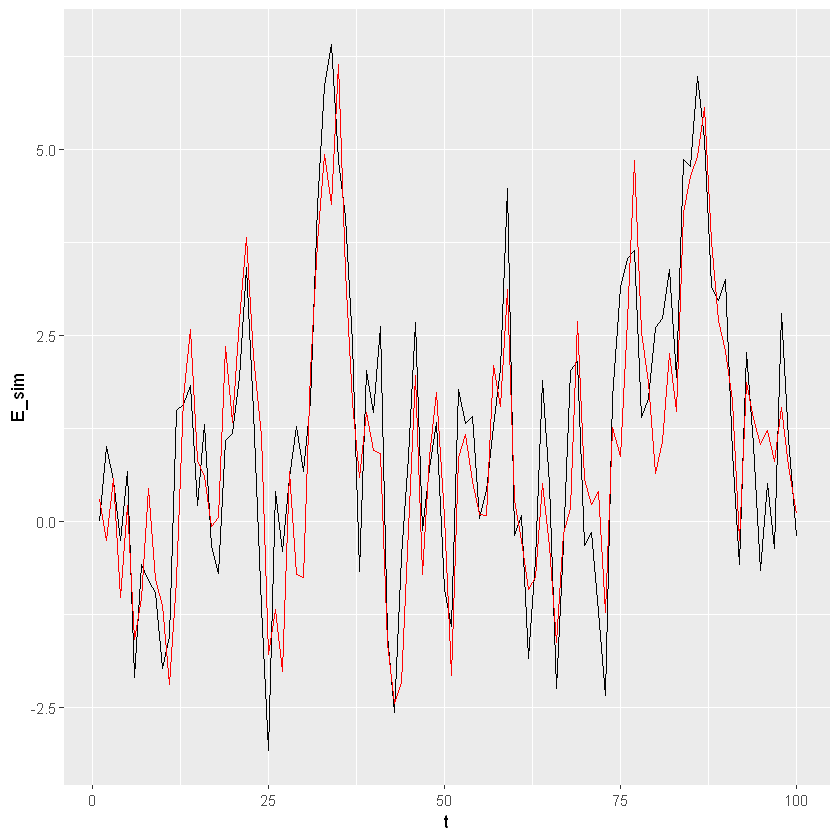

In [34]:
g <- ggplot(data = datos, aes(x = t))
g + geom_line(aes(y = E_sim)) + geom_line(aes(y = E_est), colour = "red")

### 3.3 Estimación a través de Máxima Verosimilitud

Si se considera que $\mathbf{v}_t$ y $\mathbf{w}_t$ se distribuyen de manera gausianna conjuntamente, entonces:

$$\mathbf{y}_t | \mathcal{Y}_{t - 1} \sim N((\mathbf{A}'\mathbf{x}_t + \mathbf{H}'\mathbf{\hat{\xi}}_{t|t - 1}), (\mathbf{H}'\mathbf{P}_{t|t - 1}\mathbf{H} + \mathbf{R}))$$

donde:

$$f_{\mathbf{Y}_t|\mathcal{Y}_{t - 1}}(\mathbf{y}_t | \mathcal{Y}_{t - 1}) = (2 \pi)^{-n / 2}|\mathbf{H}'\mathbf{P}_{t|t - 1}\mathbf{H} + \mathbf{R}|^{-1 / 2} \times exp[(- 1 / 2)(\mathbf{y}_t - \mathbf{A}'\mathbf{x}_t - \mathbf{H}'\mathbf{\hat{\xi}}_{t|t - 1})'(\mathbf{H}'\mathbf{P}_{t|t - 1}\mathbf{H} + \mathbf{R})^{-1}(\mathbf{y}_t - \mathbf{A}'\mathbf{x}_t - \mathbf{H}'\mathbf{\hat{\xi}}_{t|t - 1})] \text{ para } t = 1, 2, \dots, T$$

In [6]:
w <- rnorm(100, mean = 0, sd = 2); y <- rep(0, 100)
for (i in 1:100) {
    y[i] <- 2.1 * x[i] + 0.8 * E_sim[i] + w[i]
}

entonces la función de verosimilitud sería:

$$f_{\mathbf{Y_T, Y_{T - 1}, \dots,Y_1}|\mathcal{Y}_0}(\mathbf{y_T, y_{T - 1}, \dots, y_1}|\mathcal{Y}_0) = \prod^T_{t = 1} f_{\mathbf{Y}_t|\mathcal{Y}_{t - 1}}(\mathbf{y}_t|\mathcal{Y}_{t - 1})$$

expresada en logaritmos sería:

$$\log f_{\mathbf{Y_T, Y_{T - 1}, \dots,Y_1}|\mathcal{Y}_0}(\mathbf{y_T, y_{T - 1}, \dots, y_1}|\mathcal{Y}_0) = -(Tn/2) \log(2 \pi) - (1/2) \sum^T_{t = 1} \log |\mathbf{H}'\mathbf{P}_{t|t - 1}\mathbf{H} + \mathbf{R}| - (1 / 2) \sum^T_{t = 1} (\mathbf{y}_t - \mathbf{A}'\mathbf{x}_t - \mathbf{H}'\mathbf{\hat{\xi}}_{t|t - 1})'(\mathbf{H}'\mathbf{P}_{t|t - 1}\mathbf{H} + \mathbf{R})^{-1}(\mathbf{y}_t - \mathbf{A}'\mathbf{x}_t - \mathbf{H}'\mathbf{\hat{\xi}}_{t|t - 1})$$

Podemos ilustrar esto para el caso de una serie de tiempo univariante:

$$\xi_{t + 1} = 0.6 \xi_t + v_{t + 1}$$

La ecuación de observación sería:
$$y_t = 0.4 \xi_t + w_{t + 1}$$

In [83]:
set.seed(12345)
v <- rnorm(100, mean = 0, sd = 2); E_sim <- rep(0, 100)
for (i in 2:100) {
    E_sim[i] <- 0.6 * E_sim[i - 1] + v[i]
}

In [84]:
w <- rnorm(100, mean = 0, sd = 1); y <- rep(0, 100)
for (i in 1:100) {
    y[i] <- 0.4 * E_sim[i] + w[i]
}

In [55]:
library(dlm)

In [85]:
fun_dlm <- function(param) {
    FF <- param[1]; GG <- param[2]; V <- exp(param[3]); W <- exp(param[4])
    dlm(FF = FF, GG = GG, V = V, W = W, m0 = 0, C0 = 1)
} 

In [86]:
MLE_mod <- dlmMLE(y = y, parm = c(1, 0.5, 1, 1), build = fun_dlm, hessian = TRUE)

In [87]:
par_est <- MLE_mod$par
par_est

[1] 0.08894607 0.68148500 0.13549977 4.66300725

In [88]:
Kalman_res <- dlmFilter(y, mod = dlm(FF = par_est[1], GG = par_est[2], V = exp(par_est[3]), W = exp(par_est[4]), 
                                    m0 = 0, C0 = 1))

In [89]:
datos <- data.frame(t = 1:100, E_sim = E_sim, E_est = Kalman_res$a)

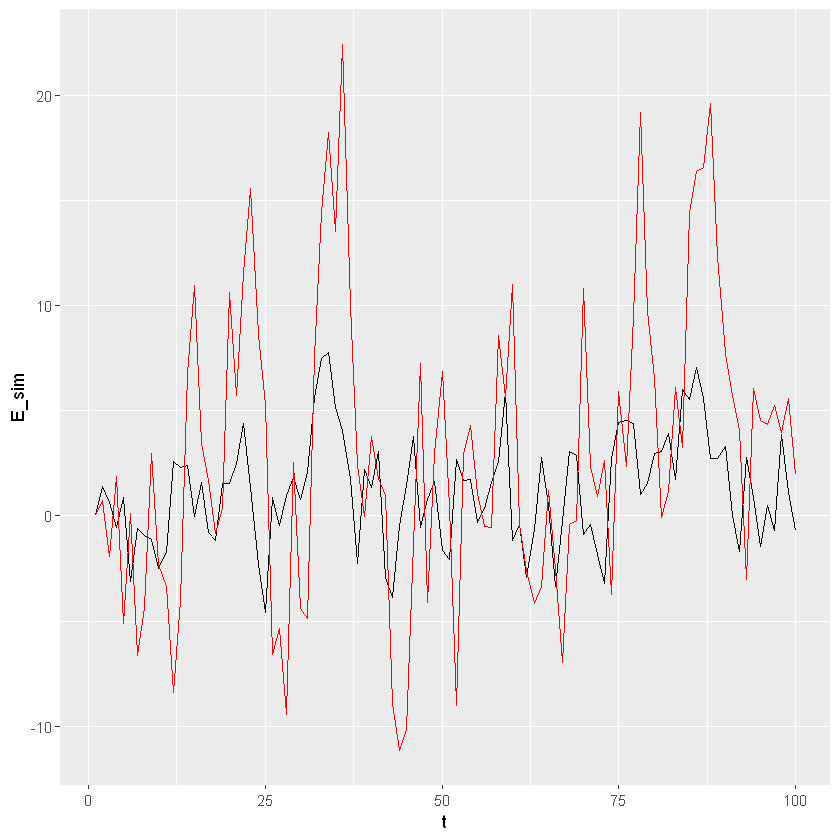

In [90]:
g <- ggplot(data = datos, aes(x = t))
g + geom_line(aes(y = E_sim)) + geom_line(aes(y = E_est), colour = "red")

### 3.4 Suavizamiento

Muchas veces es de interés el valor de la(s) variable(s) estado $\mathbf{\xi}_t$ por lo tanto quisieramos estimar cada valor $t$ de la(s) variable(s) estado utilizando toda la información muestral $\mathcal{Y}_T$, es decir, nos insteresa calcular:

$$\mathbf{\hat{\xi}}_{t|T} = \hat{E}(\mathbf{\xi}_t|\mathcal{Y}_T)$$

donde el respectivo MSE sería:

$$\mathbf{P}_{t|T} = E[(\mathbf{\xi}_t - \mathbf{\hat{\xi}}_{t|T})(\mathbf{\xi}_t - \mathbf{\hat{\xi}}_{t|T})']$$

La idea para construir esta secuencia de variables estado suavizadas es partir de $\mathbf{\hat{\xi}}_{t|t}$ y actaulizar este valor asumiendo que se observa $\mathbf{\xi}_{t + 1}$ entonces:

$$\hat{E}(\mathbf{\xi}_t|\mathbf{\xi}_{t + 1}, \mathcal{Y}_t) = \mathbf{\hat{\xi}}_{t|t} + E[(\mathbf{\xi}_t - \mathbf{\hat{\xi}}_{t|t})(\mathbf{\xi}_{t + 1} - \mathbf{\hat{\xi}}_{t + 1|t})'] \times E[(\mathbf{\xi}_{t + 1} - \mathbf{\hat{\xi}}_{t + 1|t})(\mathbf{\xi}_{t + 1} - \mathbf{\hat{\xi}}_{t + 1|t})']^{-1} \times (\mathbf{\xi}_{t + 1} - \mathbf{\hat{\xi}}_{t + 1|t})$$

que quedaría como:

$$\hat{E}(\mathbf{\xi}_t|\mathbf{\xi}_{t + 1}, \mathcal{Y}_T) = \mathbf{\hat{\xi}}_{t|t} + \mathbf{J}_t(\mathbf{\xi}_{t + 1} - \mathbf{\hat{\xi}}_{t + 1|t})$$

donde:

$$\mathbf{J}_t = \mathbf{P}_{t|t}\mathbf{F}'\mathbf{P}^{-1}_{t + 1|t}$$

Finalmente se tiene:

$$\mathbf{\hat{\xi}}_{t|T} = \hat{E}(\mathbf{\xi}_t|\mathcal{Y}_T) = \mathbf{\hat{\xi}}_{t|t} + \mathbf{J}_t(\mathbf{\hat{\xi}}_{t + 1|T} - \mathbf{\hat{\xi}}_{t + 1|t})$$

que se calcula hacia atrás una vez aplicadas las ecuaciones originales del Filtro de Kalman. Se tiene algo similar para el MSE:

$$\mathbf{P}_{t|T} = \mathbf{P}_{t|t} + \mathbf{J}_t(\mathbf{P}_{t + 1|T} - \mathbf{P}_{t + 1|t})\mathbf{J}'_t$$

Podemos ilustrar esto con el siguiente ejemplo. Sea la ecuación de estado:

$$\xi_{t + 1} = 0.8 \xi_t + v_{t + 1}$$

donde $v_t \sim N(0, 2)$ y la ecuación de observación:

$$y_t = 1.3 \xi_t + w_t$$

donde $w_t \sim N(0, 4)$.

In [91]:
set.seed(12345)
v <- rnorm(100, mean = 0, sd = sqrt(2)); E_sim <- rep(0, 100)
for (i in 2:100) {
    E_sim[i] <- 0.8 * E_sim[i - 1] + v[i]
}

In [92]:
w <- rnorm(100, mean = 0, sd = 2); y <- rep(0, 100)
for (i in 1:100) {
    y[i] <- 1.3 * E_sim[i] + w[i]
}

In [93]:
Kalman_mod <- dlm(FF = 1.3, GG = 0.8, V = 4, W = 2, m0 = 0, C0 = 10)

In [98]:
Kalman_smooth <- dlmSmooth(y, mod = Kalman_mod)
Kalman_est <- dlmFilter(y, mod = Kalman_mod)

In [99]:
datos <- data.frame(t = 1:100, E_sim = E_sim, E_s = Kalman_smooth$s[2:101], E_est = Kalman_est$a)

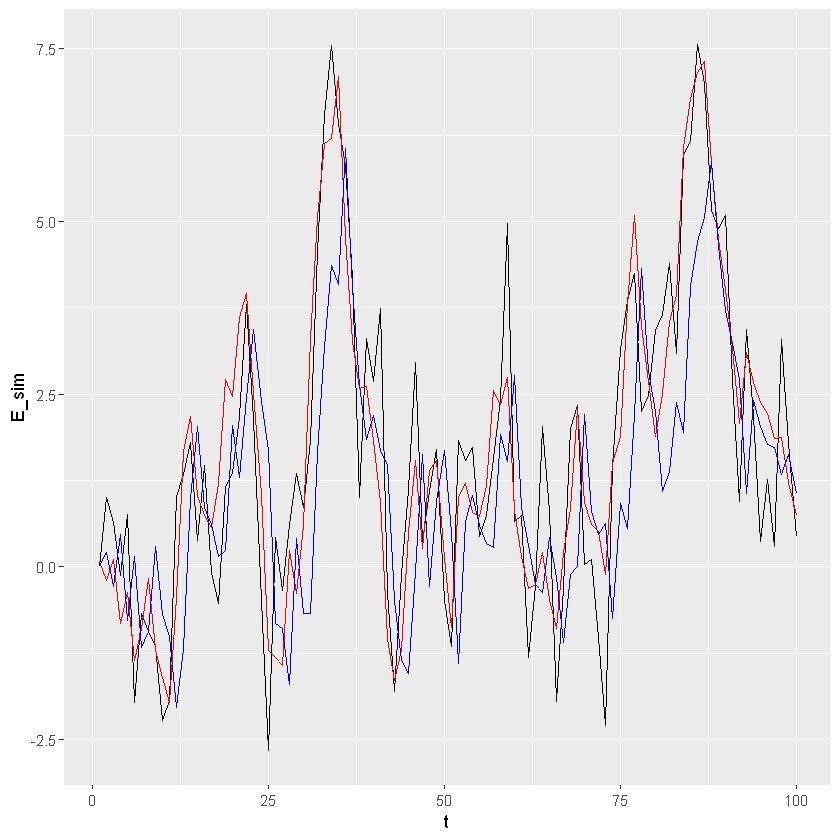

In [100]:
g <- ggplot(data = datos, aes(x = t))
g + geom_line(aes(y = E_sim)) + geom_line(aes(y = E_s), colour = "red") + geom_line(aes(y = E_est), colour = "blue")

### 3.5 Coeficientes que varían en el tiempo

Es posible generalizar el Filtro de Kalman para el caso de coeficientes que varían en el tiempo. La ecuación estado sería:

$$\mathbf{\xi}_{t + 1} = \mathbf{F(x_t)}\mathbf{\xi}_t + \mathbf{v}_{t + 1}$$

y la ecuación observación sería:

$$\mathbf{y}_t = \mathbf{a(x_t)} + [\mathbf{H(x_t)}]'\mathbf{\xi}_t + \mathbf{w}_t$$

Se incluye el supuesto adicional que $\mathbf{v}_{t + 1}$ y $\mathbf{w}_t$ siguen una distribución normal conjunta condicional en el vector de información $\mathcal{Y}_{t - 1}$ con matricres de covarianzas $\mathbf{Q(x_t)}$ y $\mathbf{R(x_t)}$ respectivas. 

Con este supuesto adicional, las ecuaciones del Filtro de Kalman son las mismas que se expusieron al inicio de este capítulo con la diferencia de incluir las matrices de coeficientes que varían en el tiempo.

### 3.6 Caso de Estudio: Evolución de la Propensión Marginal a Consumir en Bolivia

La teoría de la propensión marginal a consumir estipula que las personas consumen una fracción constante de su ingreso, es decir:

$$C_t = k Y_t \text{ con } 0 < k < 1$$ 

Nuestro interés es en ver la evolución de este parámetro $k$ en el tiempo. Podemos utilizar la herramienta del Filtro de Kalman para ello. Consideramos $k_t$ como la variable estado que asumimos sigue el siguiente proceso AR(1):

$$k_{t + 1} = \alpha k_t + v_{t + 1}$$

y la ecuación de observación sería:

$$C_t = Y_t k_t$$

donde $\mathbf{\xi}_t = k_t$, $\mathbf{F(x_t)} = \alpha$, $\mathbf{v}_{t + 1} = v_{t + 1}$, $\mathbf{a(x_t)} = 0$, $\mathbf{H(x_t)} = Y_t$, $\mathbf{w}_t = 0$, $\mathbf{R(x_t)} = 0$, $\mathbf{Q(x_t)} = \sigma^2$.

In [102]:
setwd("..")

In [104]:
if (!file.exists("./Datos/PIB2.xlsx")) {
    url <- "https://www.ine.gob.bo/index.php/descarga/492/pib-segun-tipo-de-gasto/46189/bolivia-producto-interno-bruto-a-precios-constantes-por-tipo-de-gasto-1988-2019.xlsx"
    download.file(url, destfile = "./Datos/PIB2.xlsx", mode = "wb")
}

In [105]:
library(readxl)

In [108]:
pib <- read_xlsx("./Datos/PIB2.xlsx", sheet = 1, range = "B11:AG11", col_names = FALSE)
cons <- read_xlsx("./Datos/PIB2.xlsx", sheet = 1, range = "B13:AG13", col_names = FALSE)

New names:
* `` -> ...1
* `` -> ...2
* `` -> ...3
* `` -> ...4
* `` -> ...5
* ...

New names:
* `` -> ...1
* `` -> ...2
* `` -> ...3
* `` -> ...4
* `` -> ...5
* ...



In [110]:
Fecha <- seq(as.Date("01-01-1988", "%d-%m-%Y"), as.Date("01-01-2019", "%d-%m-%Y"), by = "year")

In [119]:
datos <- data.frame(Fecha = Fecha, C = t(cons), Y = t(pib), const = rep(1, length(Fecha)))

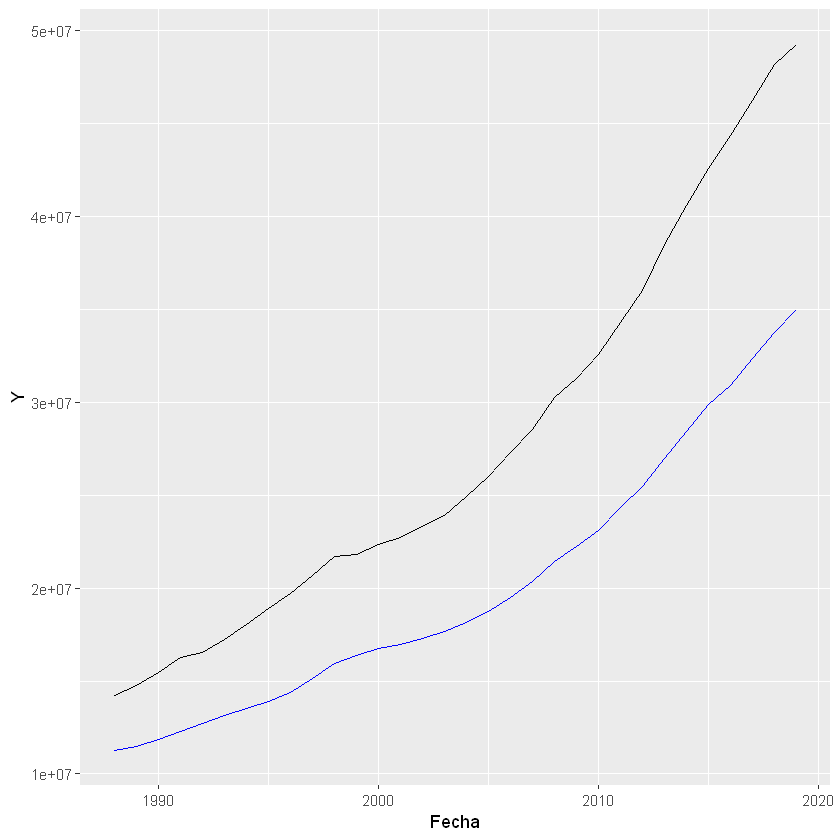

In [120]:
g <- ggplot(data = datos, aes(x = Fecha))
g + geom_line(aes(y = Y)) + geom_line(aes(y = C), colour = "blue")

In [126]:
dlm_fun <- function(param, x) {
    FF <- 1; JFF <- 1; GG <- param[1]; V <- 0; W <- exp(param[2])
    dlm(FF = JFF, JFF = JFF, GG = GG, V = V, W = W, m0 = 0.1, C0 = 10, X = x)
}

In [127]:
MLE_mod <- dlmMLE(y = datos$C, parm = c(0.5, 1), build = dlm_fun, x = as.matrix(datos[, 3]), hessian = TRUE)

In [129]:
par_est <- MLE_mod$par
par_est

[1]  0.996185 -9.834696

In [134]:
Kalman_mod <- dlm(FF = 1, JFF = 1, GG = par_est[1], V = 0, W = exp(par_est[2]), 
                  m0 = 0.1, C0 = 10, X = as.matrix(datos[, 3]))

In [132]:
Kalman_smooth <- dlmSmooth(datos$C, mod = Kalman_mod)

In [133]:
n <- length(Kalman_smooth$s)
datos$k <- Kalman_smooth$s[2:n]

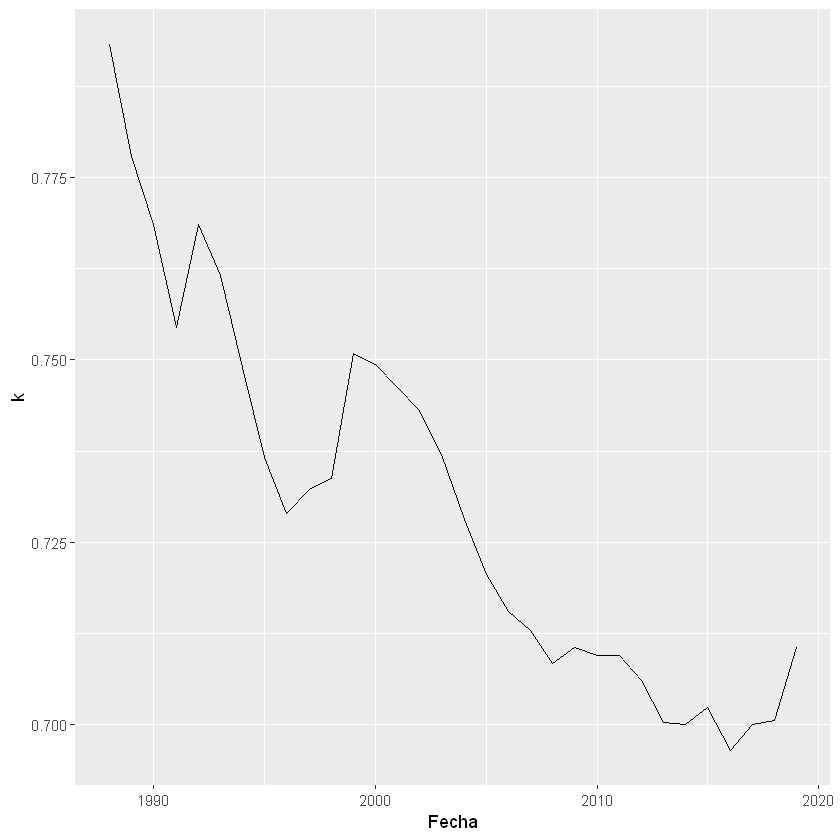

In [135]:
g <- ggplot(data = datos, aes(x = Fecha, y = k))
g + geom_line()

Los interesados en ver las implementaciones del Filtro de Kalman en R pueden verlas [aqui](https://www.stat.berkeley.edu/~brill/Stat248/kalmanfiltering.pdf).